# Step Size Analysis (step_size=0.025)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

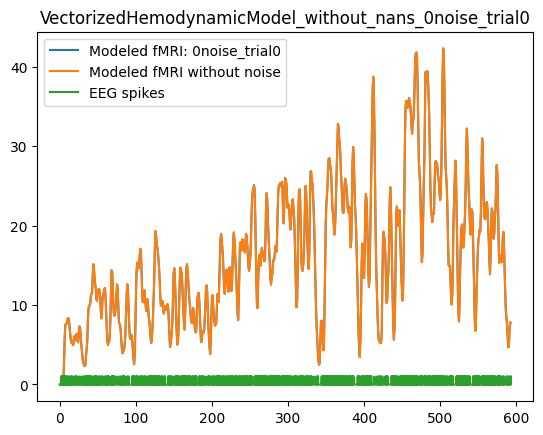

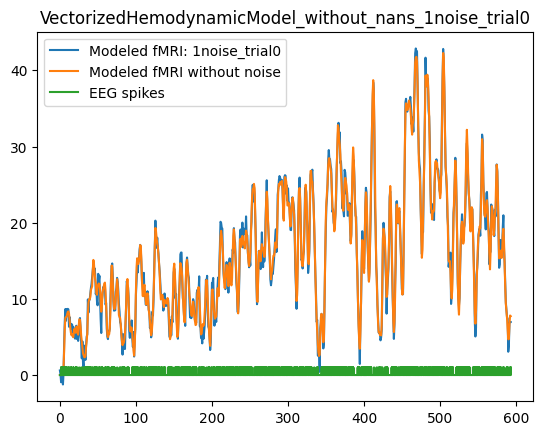

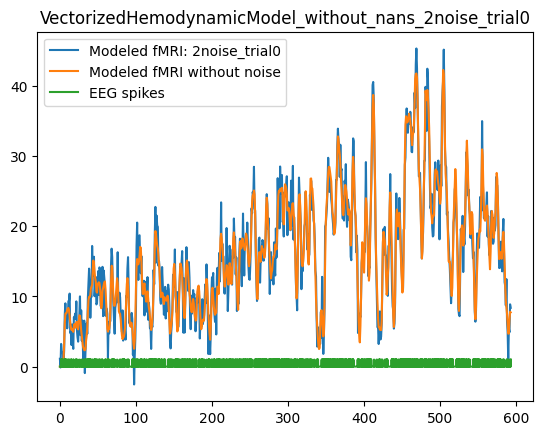

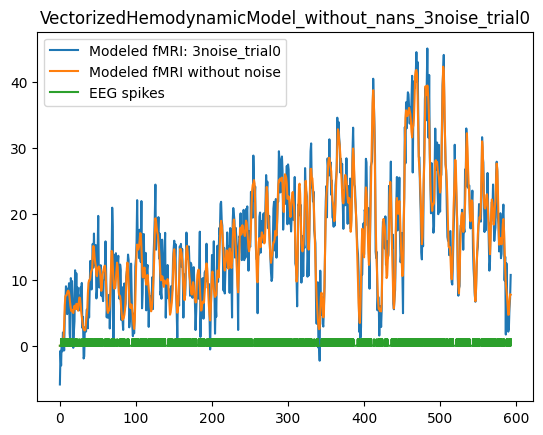

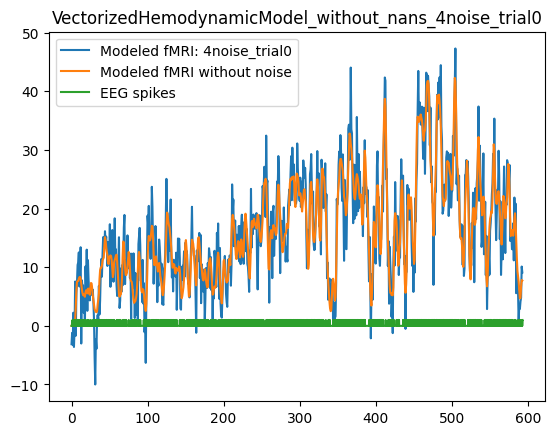

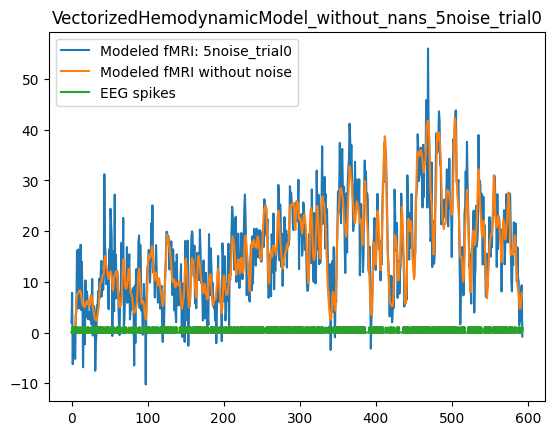

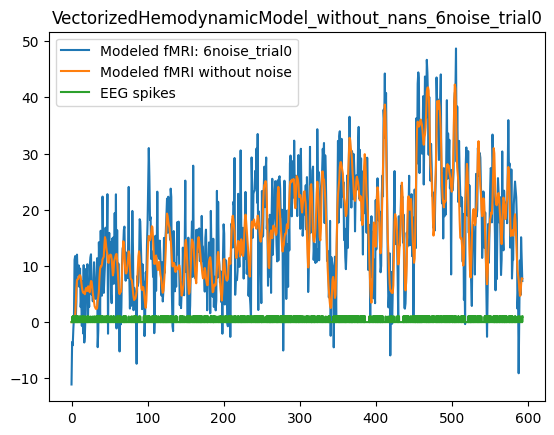

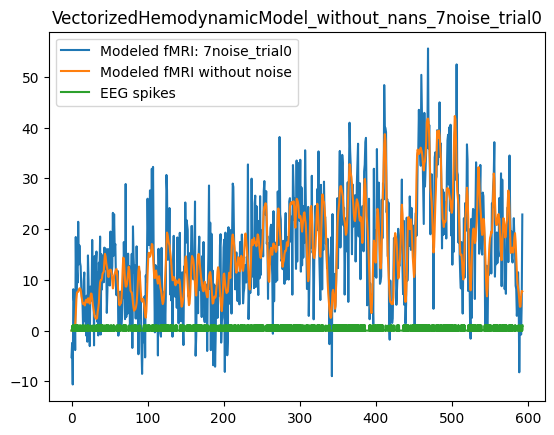

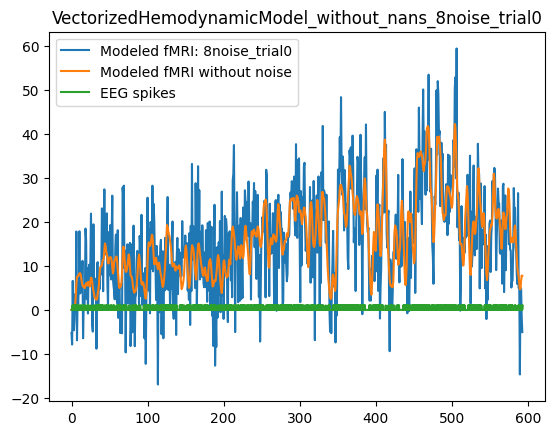

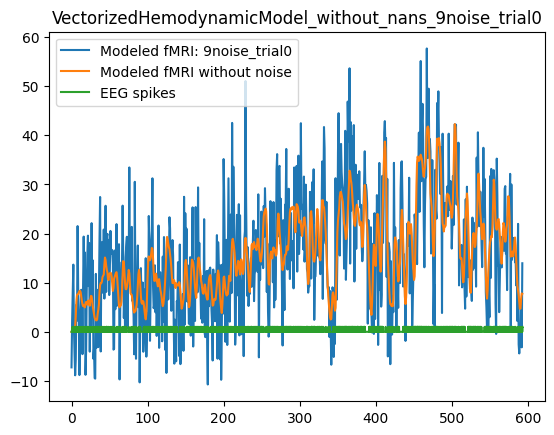

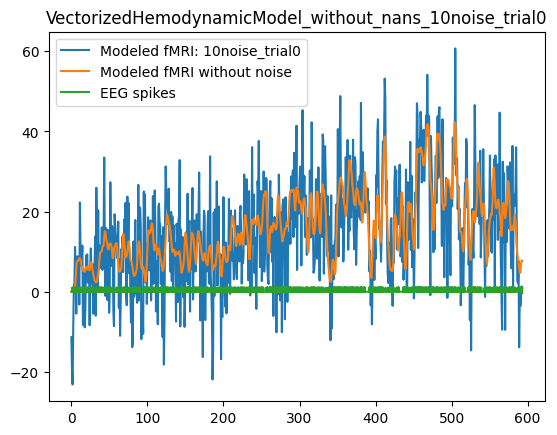

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [10]:
step_size = 0.025

filename_substring = f'effect_of_step_size_{step_size}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275
 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575
 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775 1.8   1.825 1.85  1.875
 1.9   1.925 1.95  1.975 2.    2.025 2.05  2.075 2.1   2.125 2.15  2.175
 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.375 2.4   2.425 2.45  2.475
 2.5   2.525 2.55  2.575 2.6   2.625 2.65  2.675 2.7   2.725 2.75  2.775
 2.8   2.825 2.85  2.875 2.9   2.925 2.95  2.975 3.   ]

Tau target: 1.25, Range:
[0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.    1.025
 1.05  1.075 1.1   1.125 1.15  1.175 1.2   1.225 1.25  1.275 1.3   1.325
 1.35  1.375 1.4   1.425 1.45  1.475 1.5   1.525 1.55  1.575 1.6   1.625
 1.65  1.675 1.7   1.725 1.75 ]

Alpha target: 2, Range:
[1.75  1.775 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.    2.025
 2.05  2.075 2.1   2.125 2.15  2.175 2.2   2.225 2.25 ]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=2


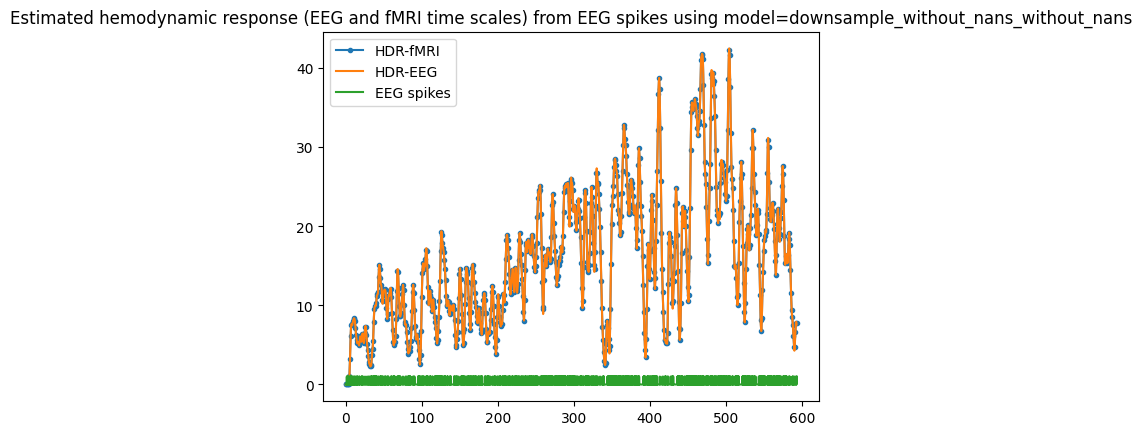

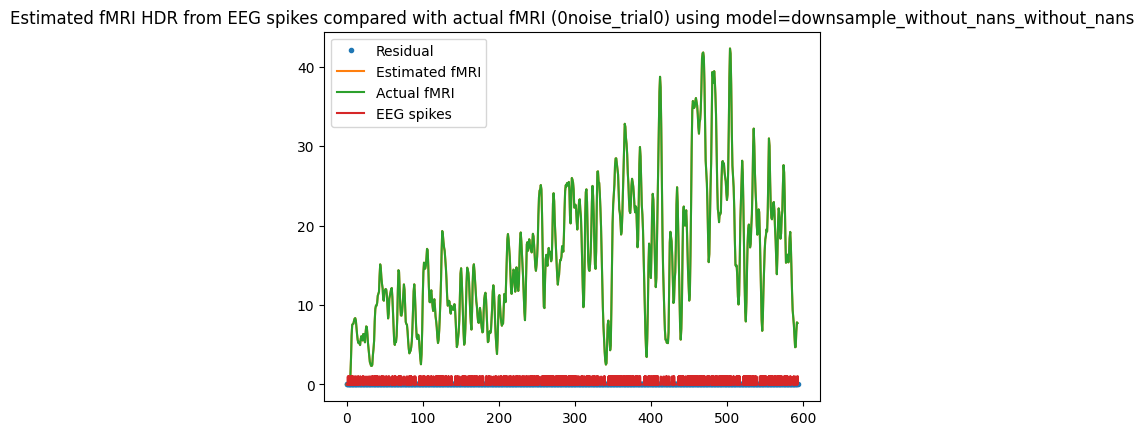

Residual Variance is 0.000000


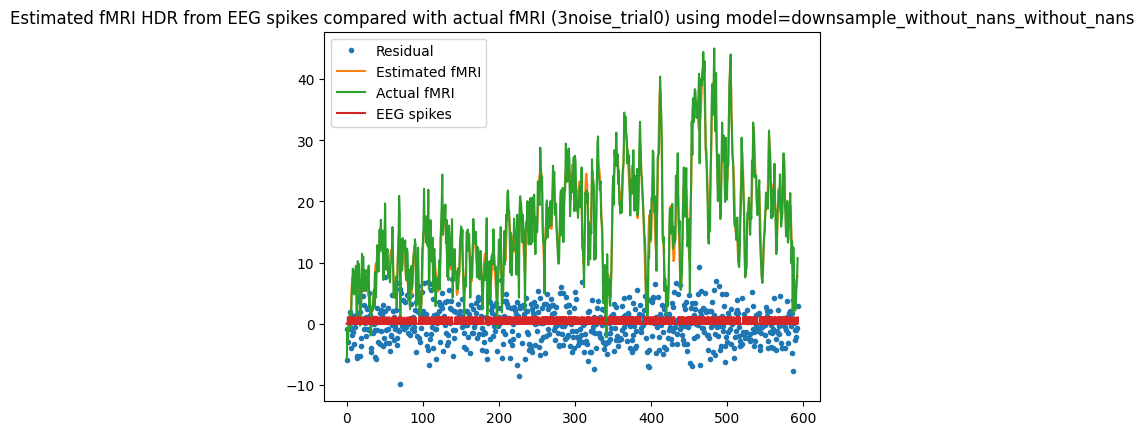

Residual Variance is 8.915922


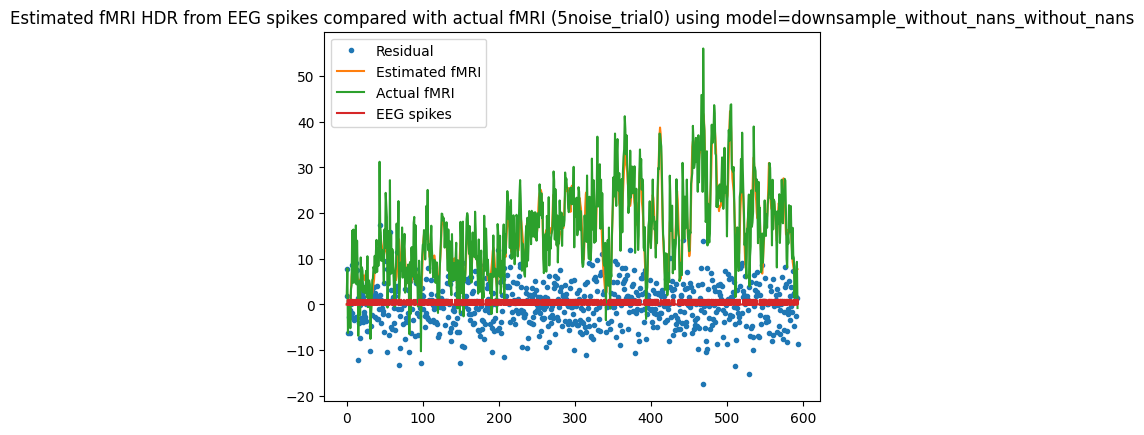

Residual Variance is 23.780132


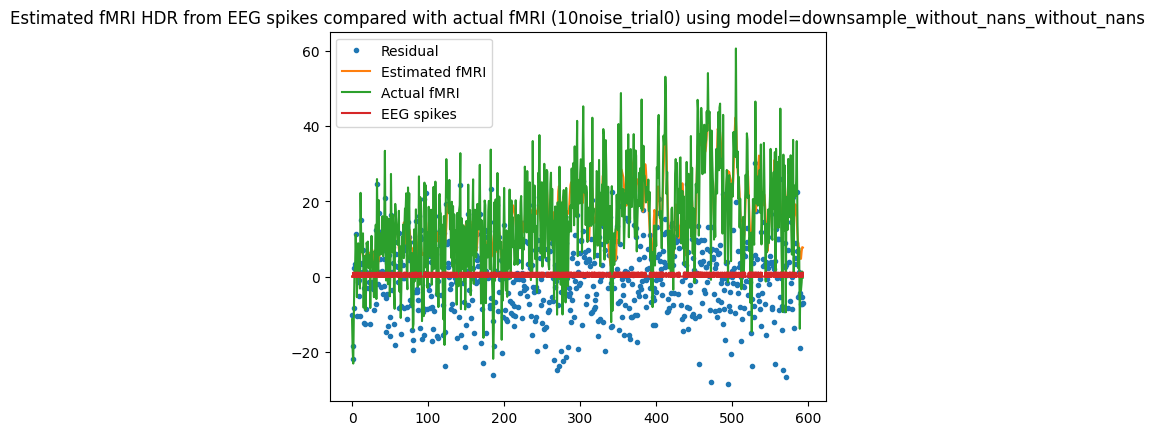

Residual Variance is 100.897805


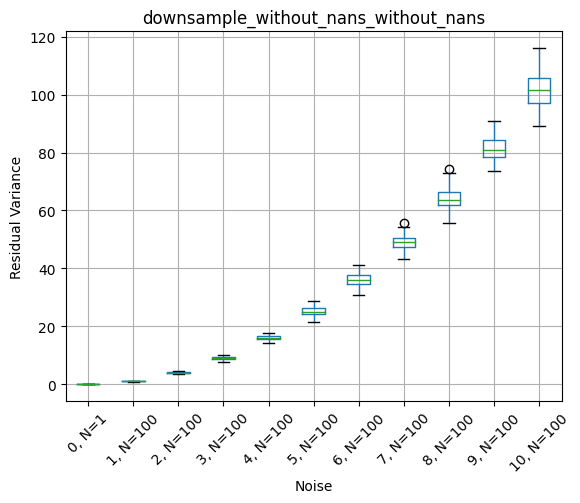

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=2


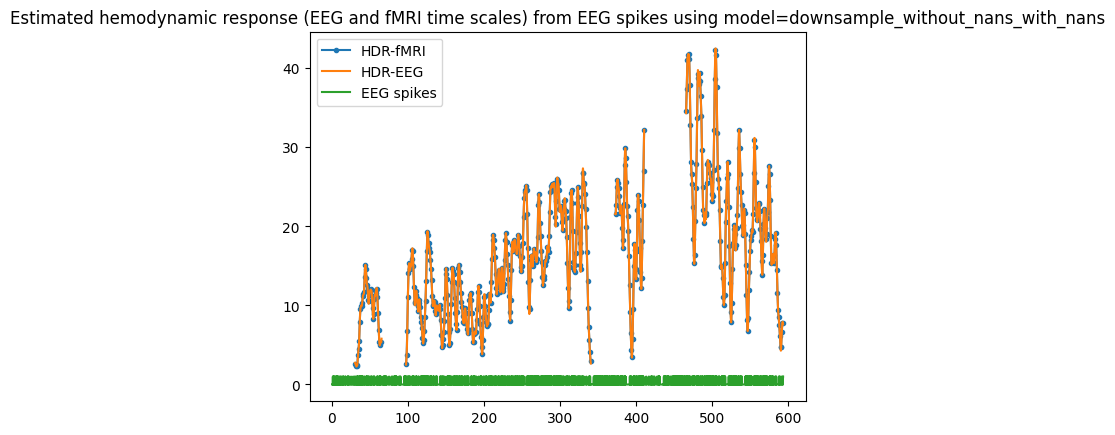

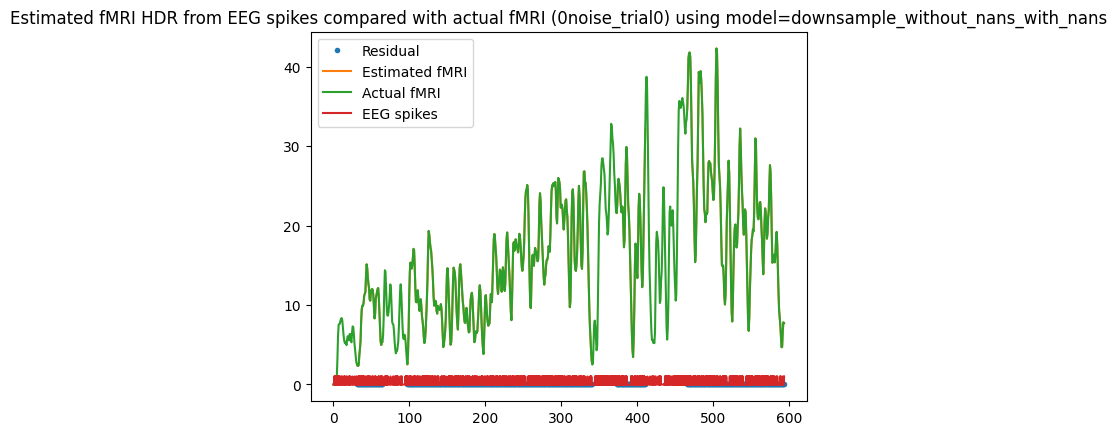

Residual Variance is 0.000000


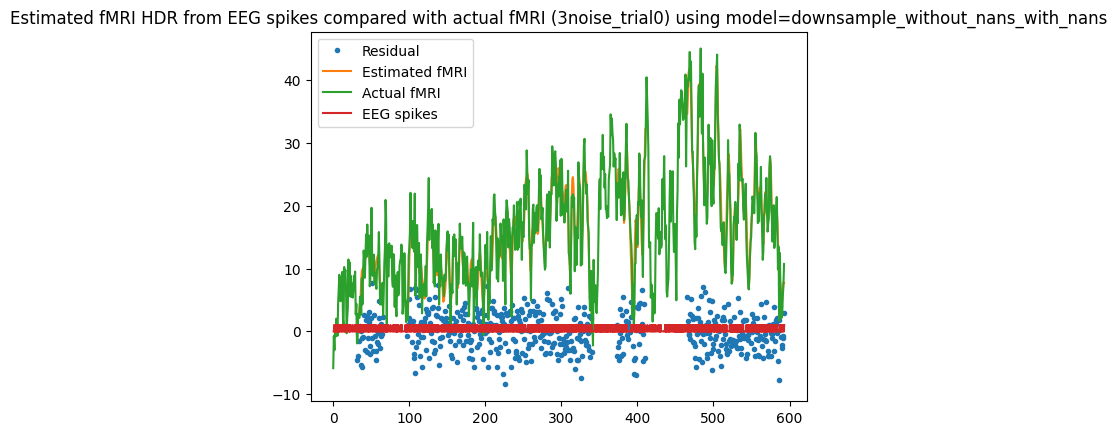

Residual Variance is 8.747384


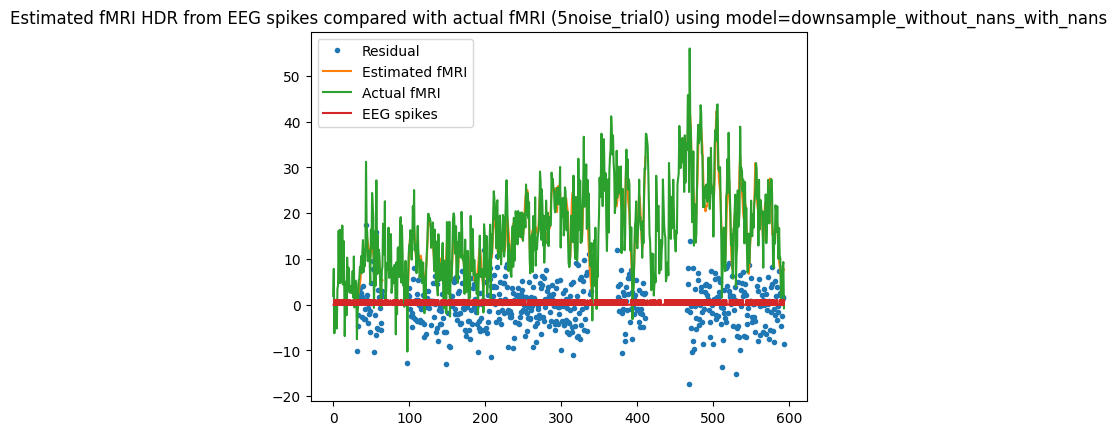

Residual Variance is 23.673040


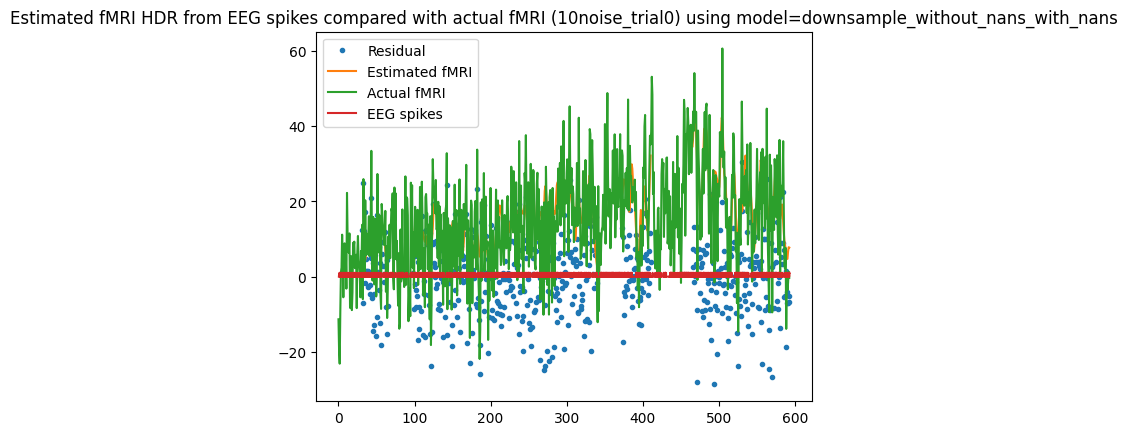

Residual Variance is 101.565186


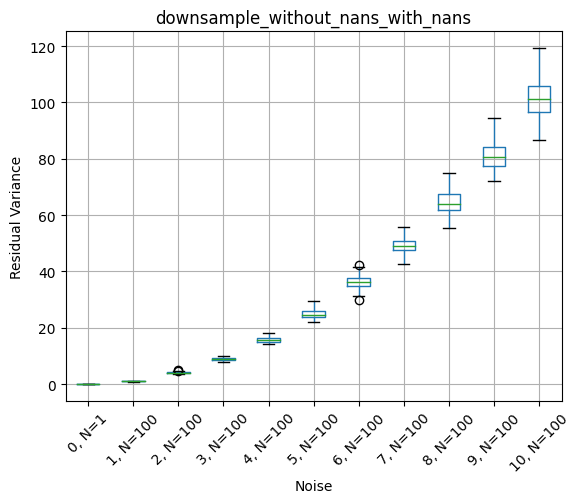

In [11]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False


## Generate/Load the full dataset

In [12]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [13]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.025
Scoring delta=1.0499999999999998
Scoring delta=1.0749999999999997
Scoring delta=1.0999999999999996
Scoring delta=1.1249999999999996
Scoring delta=1.1499999999999995
Scoring delta=1.1749999999999994
Scoring delta=1.1999999999999993
Scoring delta=1.2249999999999992
Scoring delta=1.2499999999999991
Scoring delta=1.274999999999999
Scoring delta=1.299999999999999
Scoring delta=1.3249999999999988
Scoring delta=1.3499999999999988
Scoring delta=1.3749999999999987
Scoring delta=1.3999999999999986
Scoring delta=1.4249999999999985
Scoring delta=1.4499999999999984
Scoring delta=1.4749999999999983
Scoring delta=1.4999999999999982
Scoring delta=1.5249999999999981
Scoring delta=1.549999999999998
Scoring delta=1.574999999999998
Scoring delta=1.5999999999999979
Scoring delta=1.6249999999999978
Scoring delta=1.6499999999999977
Scoring delta=1.6749999999999976
Scoring delta=1.6999999999999975
Scoring delta=1.7249999999999974
Scoring delta=1.749999999

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75               1.775   
3                     1.0                0.75               1.775   
4                     1.0                0.75  1.7999999999999998   
...                   ...                 ...                 ...   
139477  2.999999999999993  1.7500000000000009  2.1999999999999984   
139478  2.999999999999993  1.7500000000000009  2.2249999999999983   
139479  2.999999999999993  1.7500000000000009  2.2249999999999983   
139480  2.999999999999993  1.7500000000000009  2.2499999999999982   
139481  2.999999999999993  1.7500000000000009  2.2499999999999982   

                                  model_name       0noise_trial0  \
0       downsample_without_nans_without_nans   43.01781141842791   
1          downsample_without_nans_with_nans   39.26920114811135   
2       downsample_without_nans_without_nans   42.59208615702566   
3          downsample_without_nans_with_nans  38.905543290353776   
4       downsample_without_nans_without_nans   42.16412310841909   
...                                      ...                 ...   
139477     downsample_without_nans_with_nans  14.600697760467499   
139478  downsample_without_nans_without_nans   16.36705951447114   
139479     downsample_without_nans_with_nans  14.945229127284646   
139480  downsample_without_nans_without_nans   16.75726110565034   
139481     downsample_without_nans_with_nans   15.28802148033359   

             1noise_trial0       2noise_trial0       3noise_trial0  \
0        44.23443177731488   46.27717877101854  53.078444122591854   
1        40.62549429362088  42.764774833782575   48.79970015670077   
2       43.801263886172286  45.853867097760705  52.647474941820356   
3       40.255089061944965   42.40348699584096  48.435167322169164   
4       43.365903968822224   45.42840481166264   52.21391061087415   
...                    ...                 ...                 ...   
139477  15.757742657181122   19.50557691818713  24.522564817210366   
139478  17.445983579683826   21.23139439578373   26.06291736179468   
139479   16.10620042662712  19.840967381654703  24.879954146531905   
139480  17.837981279564943  21.614927246321884   26.46526216740557   
139481  16.452953627878497  20.174541918788854  25.235320762619132   

             4noise_trial0      5noise_trial0  ...      1noise_trial99  \
0        58.71723622707836  67.19447312303011  ...   43.79274496754444   
1       54.442134799815335  63.64707647945565  ...  39.876613011610644   
2       58.269845603113225  66.74267769167194  ...  43.368968447837354   
3        54.05807608737007  63.27041078065521  ...  39.515349628565744   
4        57.82048922527954  66.28887157805777  ...   42.94294294673583   
...                    ...                ...  ...                 ...   
139477   29.66909380013853  38.76449884979236  ...  15.388292386309628   
139478   32.44946373173755  41.38684792524997  ...  17.111833369797107   
139479  30.012259519571835   39.1113118481345  ...  15.729528568142783   
139480  32.847029473813635  41.78345121834063  ...   17.49906892252676   
139481  30.353555924205438  39.45620768771044  ...   16.06906822367506   

            2noise_trial99      3noise_trial99      4noise_trial99  \
0       45.959280720615595   52.27585923508403   61.60911054971506   
1        42.76004152861919  47.816024502680776  54.836991080143285   
2        45.52917066193647   51.84043357190634   61.17977266555632   
3       42.390603551426466   47.42545174092678   54.47981320658668   
4        45.09713600920518    51.4030521877404  60.747775235418715   
...                    ...                 ...                 ...   
139477  18.424501449456706  24.687989276280266  29.995822195857716   
139478  20.483214581824825  25.561736749139268  31.476207163900963   
139479  18.767

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 2.0666791637868276e-28; at
       delta   tau  alpha
86960   2.25  1.25    2.0


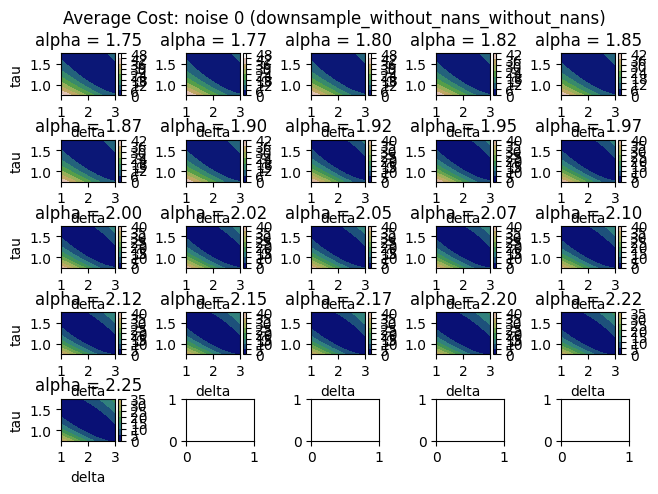

delta   tau  alpha  \
0         1.0  0.75  1.750   
2         1.0  0.75  1.775   
4         1.0  0.75  1.800   
6         1.0  0.75  1.825   
8         1.0  0.75  1.850   
...       ...   ...    ...   
139472    3.0  1.75  2.150   
139474    3.0  1.75  2.175   
139476    3.0  1.75  2.200   
139478    3.0  1.75  2.225   
139480    3.0  1.75  2.250   

        Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                               43.017811             
2                                               42.592086             
4                                               42.164123             
6                                               41.734007             
8                                               41.301824             
...                                                   ...             
139472                                          15.190117             
139474                                          15.583331             
139476                                          15.975699             
139478                                          16.367060             
139480                                          16.757261             

[69741 rows x 4 columns]

In [14]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [15]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [16]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta    tau  alpha
0      0         0  5.632196e-03  2.150  1.175  2.250
1      0         0  2.726542e-03  2.175  1.200  2.175
2      0         0  9.070503e-04  2.225  1.225  2.075
3      0         0  2.066679e-28  2.250  1.250  2.000
4      0         0  1.155631e-03  2.275  1.275  1.925
5      0         0  2.228526e-03  2.325  1.300  1.850
6      0         0  5.345513e-03  2.350  1.325  1.775

In [17]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         7.0

#### Local minima at edges

In [18]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [20]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [21]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [22]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [23]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta    tau  alpha
0      0         0  0.005632   2.15  1.175   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.1262048151448987e-28; at
       delta   tau  alpha
86961   2.25  1.25    2.0


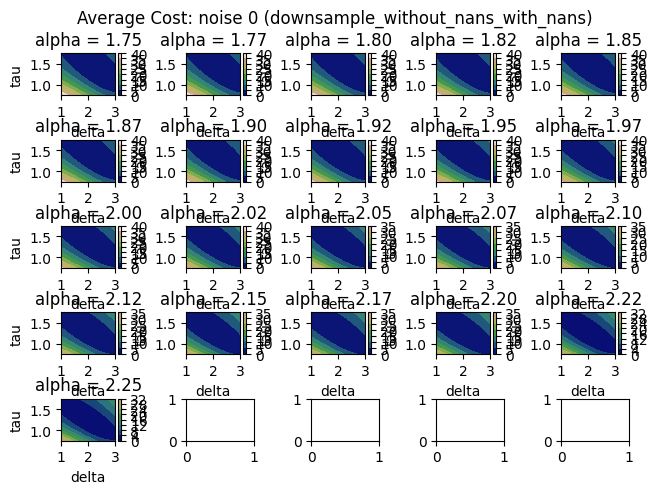

delta   tau  alpha  \
1         1.0  0.75  1.750   
3         1.0  0.75  1.775   
5         1.0  0.75  1.800   
7         1.0  0.75  1.825   
9         1.0  0.75  1.850   
...       ...   ...    ...   
139473    3.0  1.75  2.150   
139475    3.0  1.75  2.175   
139477    3.0  1.75  2.200   
139479    3.0  1.75  2.225   
139481    3.0  1.75  2.250   

        Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                               39.269201          
3                                               38.905543          
5                                               38.539250          
7                                               38.170389          
9                                               37.799030          
...                                                   ...          
139473                                          13.906968          
139475                                          14.254563          
139477                                          14.600698          
139479                                          14.945229          
139481                                          15.288021          

[69741 rows x 4 columns]

In [24]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [25]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0   2.25  1.25    2.0

### Local Minima Analysis

In [26]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta    tau  alpha
0      0         0  5.535458e-03  2.150  1.175  2.250
1      0         0  2.745094e-03  2.175  1.200  2.175
2      0         0  8.995116e-04  2.225  1.225  2.075
3      0         0  2.126205e-28  2.250  1.250  2.000
4      0         0  1.158932e-03  2.275  1.275  1.925
5      0         0  2.149170e-03  2.325  1.300  1.850
6      0         0  5.319907e-03  2.350  1.325  1.775

In [27]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         7.0

#### Local minima at edges

In [28]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [30]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [31]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [32]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [33]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta    tau  alpha
0      0         0  0.005535   2.15  1.175   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 1.0042858986859138; at
       delta   tau  alpha
86960   2.25  1.25    2.0


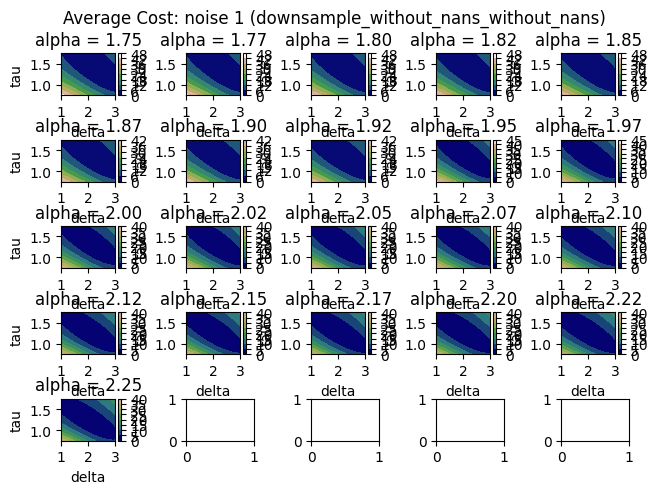

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.041502748650413; at
       delta   tau  alpha
86960   2.25  1.25    2.0


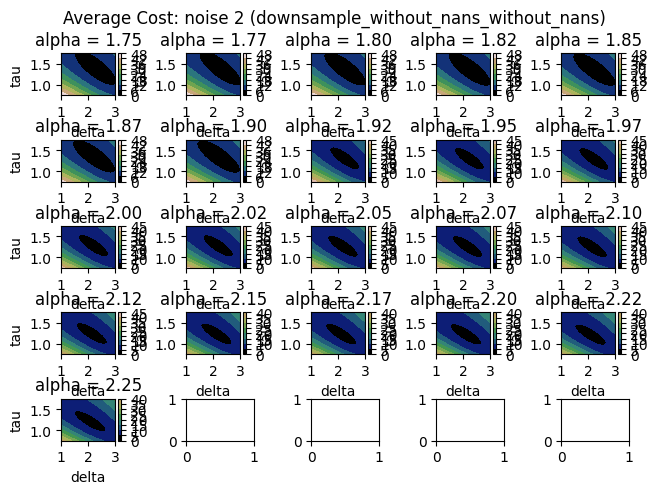

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.891517250902416; at
       delta    tau  alpha
88718  2.275  1.275  1.925


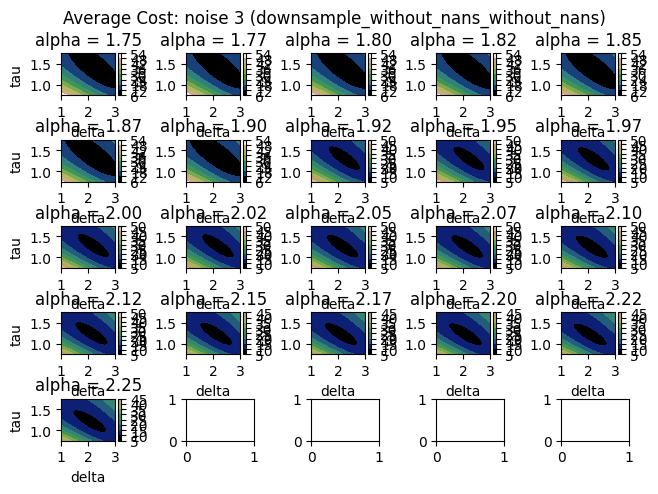

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.955652169742578; at
       delta    tau  alpha
88718  2.275  1.275  1.925


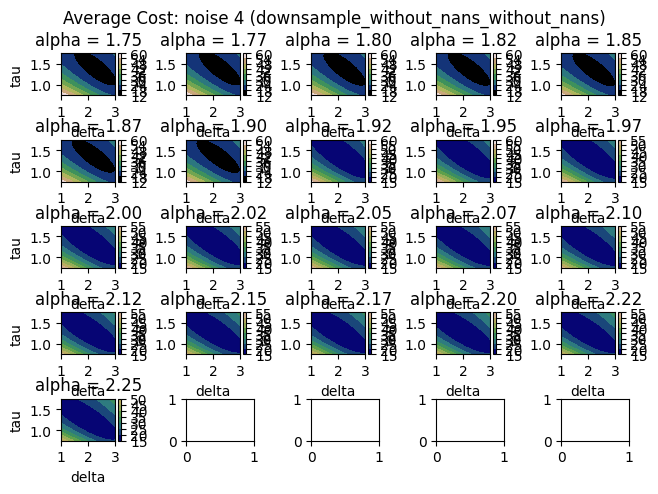

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.132229367268295; at
       delta   tau  alpha
86960   2.25  1.25    2.0


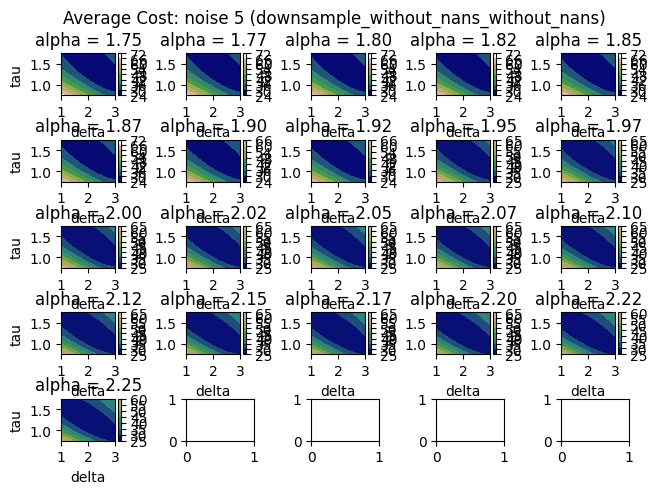

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.147155340857424; at
       delta    tau  alpha
85202  2.225  1.225  2.075


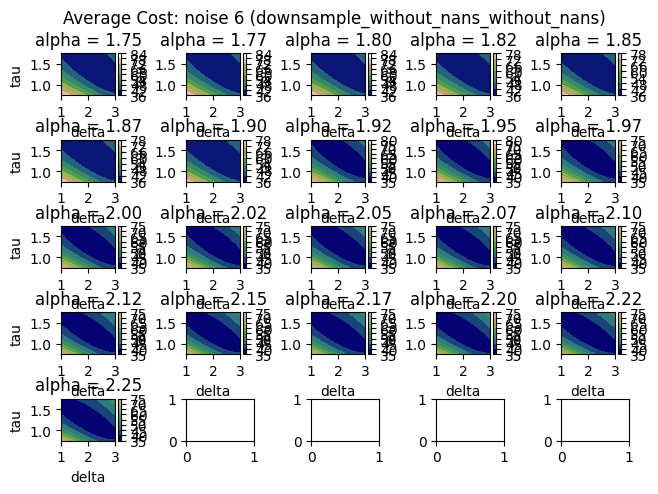

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.12004052683227; at
       delta    tau  alpha
86922   2.25  1.225   2.05


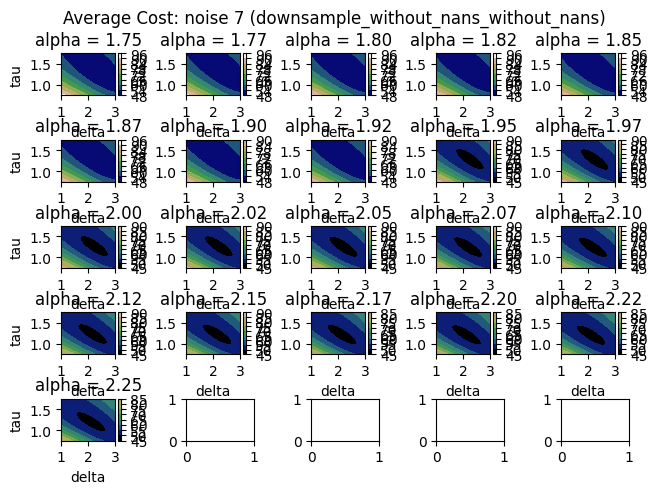

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.20883895402531; at
       delta    tau  alpha
85202  2.225  1.225  2.075


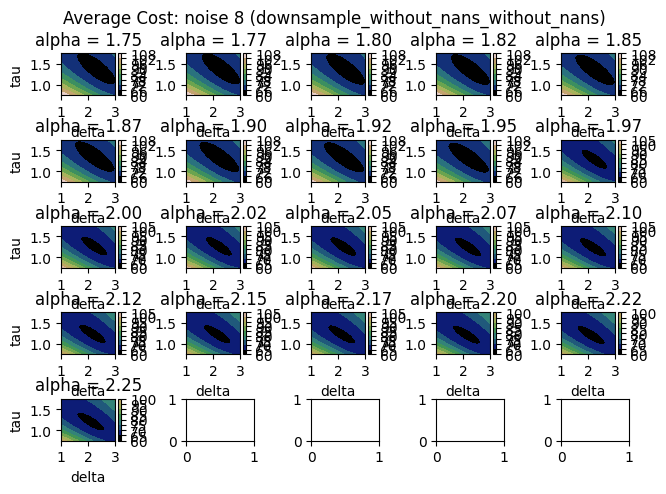

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.37399834831592; at
       delta   tau  alpha
92122  2.325  1.25   1.95


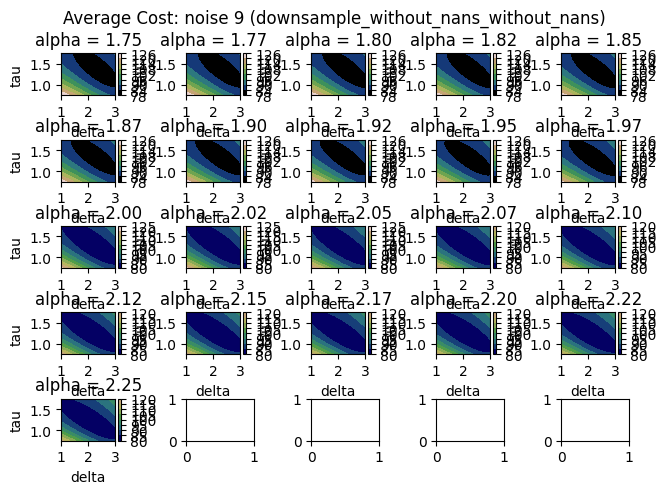

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 101.7637214375994; at
       delta    tau  alpha
95600  2.375  1.275   1.85


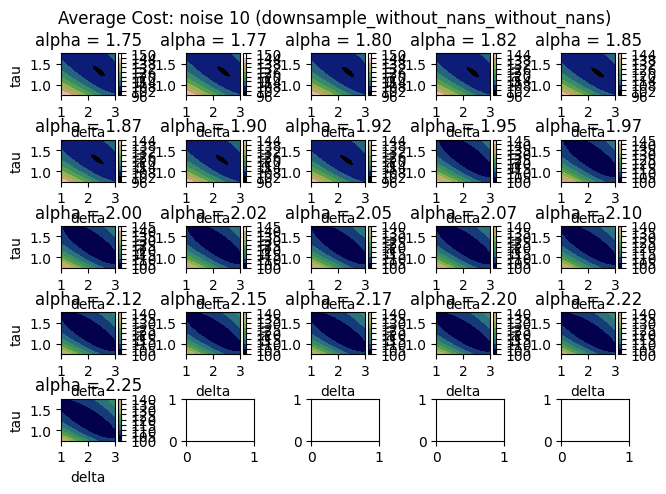

In [34]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

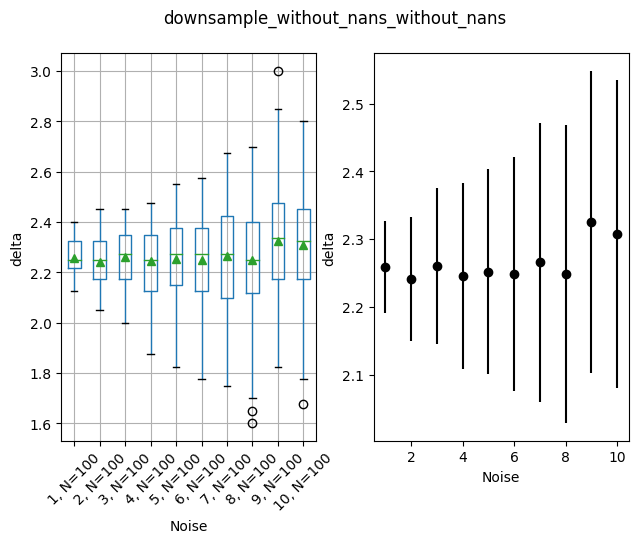

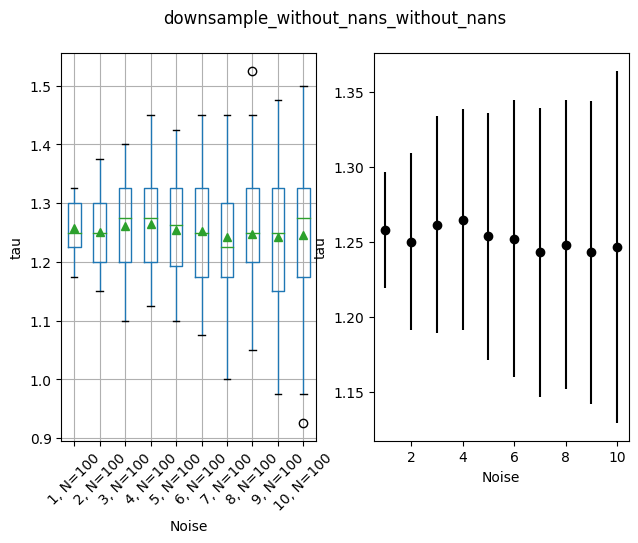

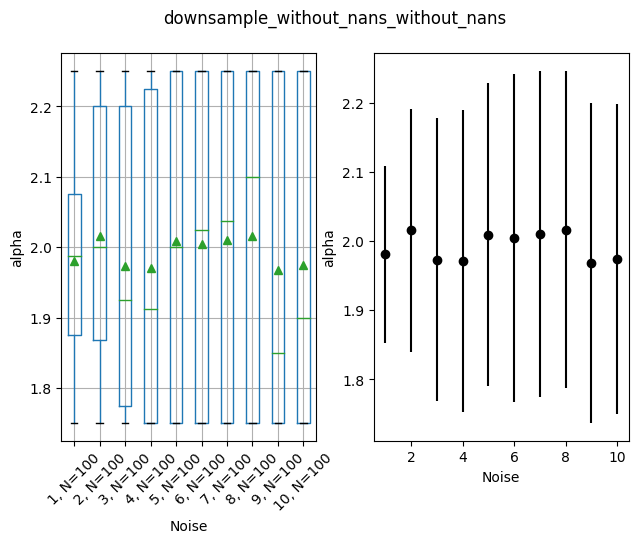

In [35]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0106171275416216; at
       delta   tau  alpha
86961   2.25  1.25    2.0


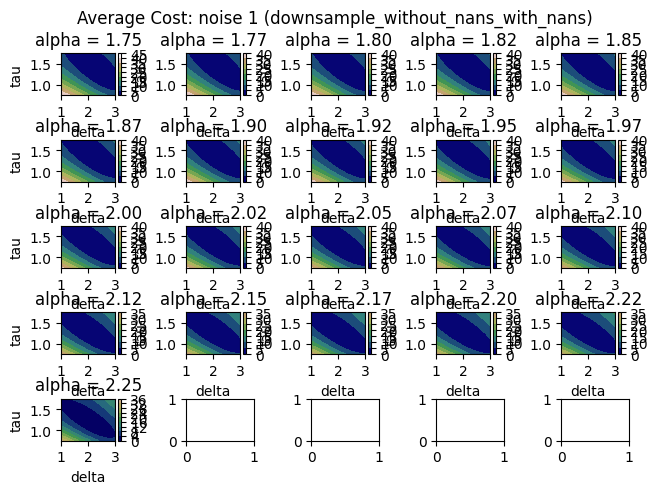

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.035392027061938; at
       delta   tau  alpha
86961   2.25  1.25    2.0


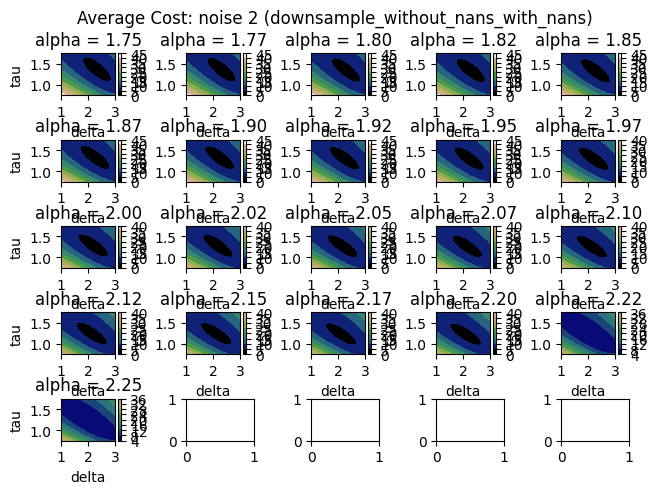

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.900200890546756; at
       delta    tau  alpha
88719  2.275  1.275  1.925


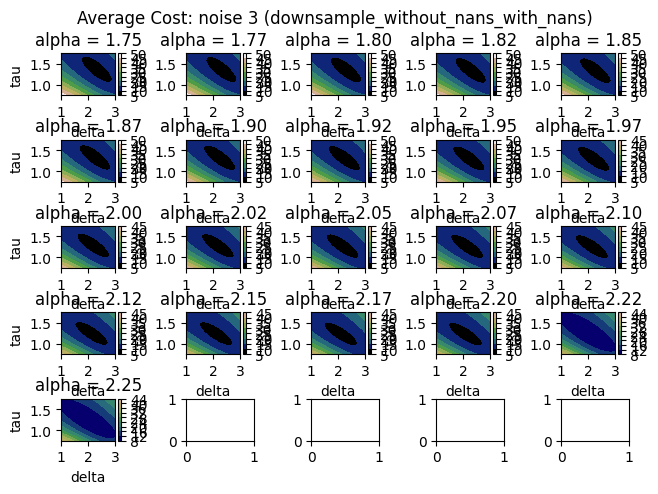

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.868667309337363; at
       delta    tau  alpha
88719  2.275  1.275  1.925


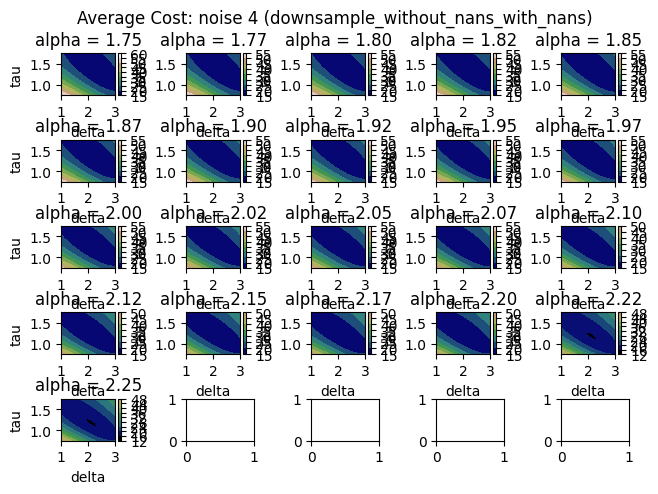

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.0013969999868; at
       delta    tau  alpha
83483    2.2  1.225    2.1


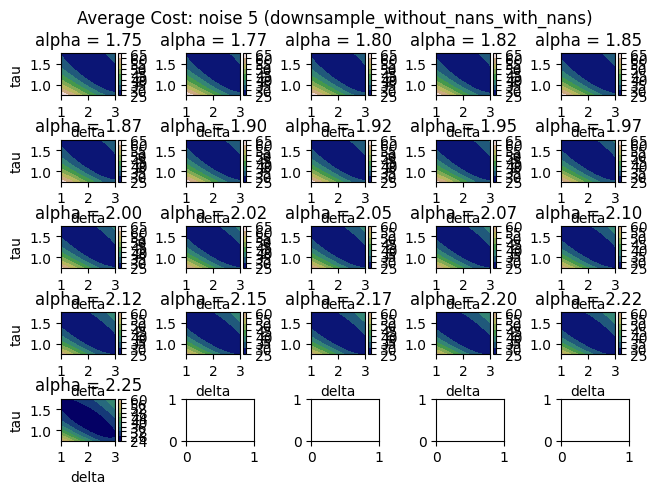

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.25481963438695; at
       delta    tau  alpha
83483    2.2  1.225    2.1


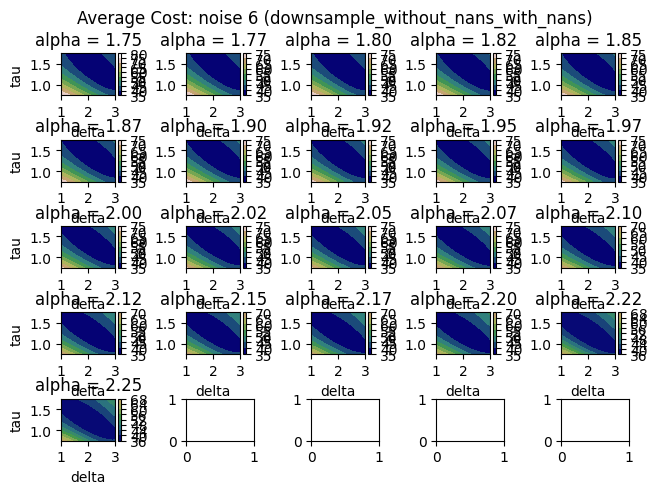

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.271089417981806; at
       delta   tau  alpha
88681  2.275  1.25  1.975


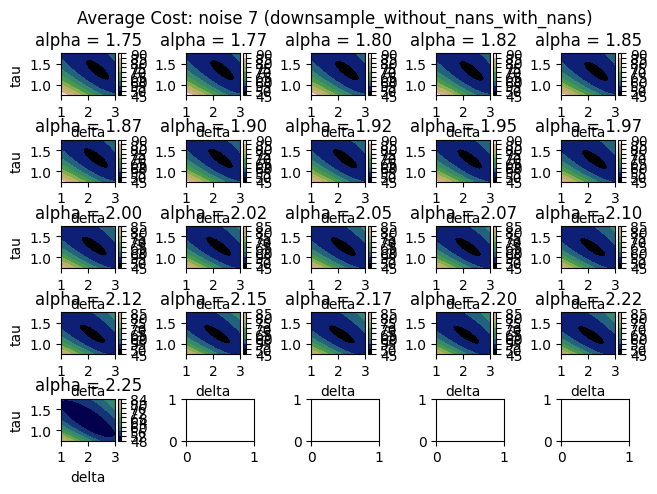

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 64.49503644947734; at
       delta   tau  alpha
85241  2.225  1.25  2.025


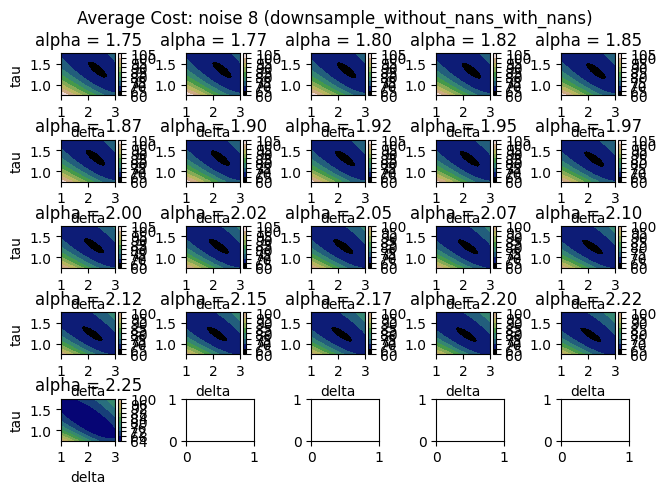

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.94872011686648; at
       delta    tau  alpha
92085  2.325  1.225    2.0


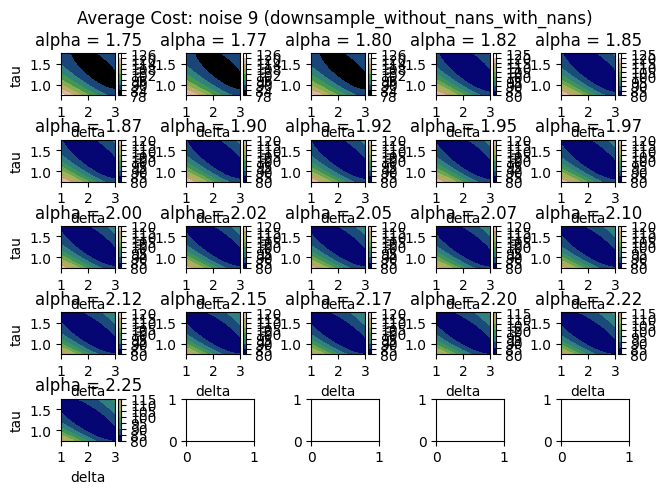

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 101.88866830873886; at
       delta    tau  alpha
97321    2.4  1.275  1.825


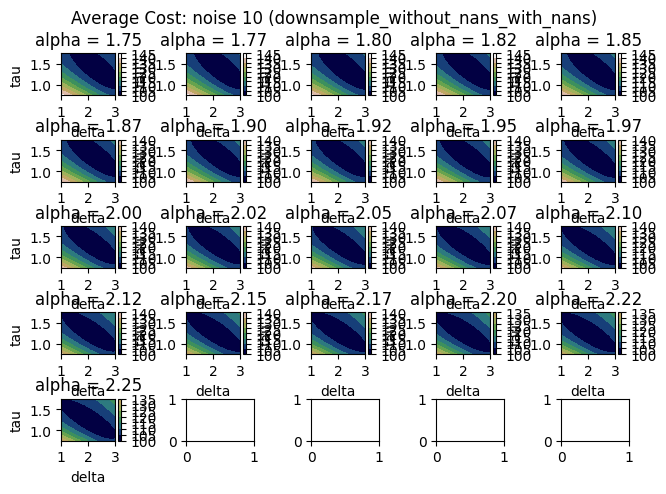

In [36]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


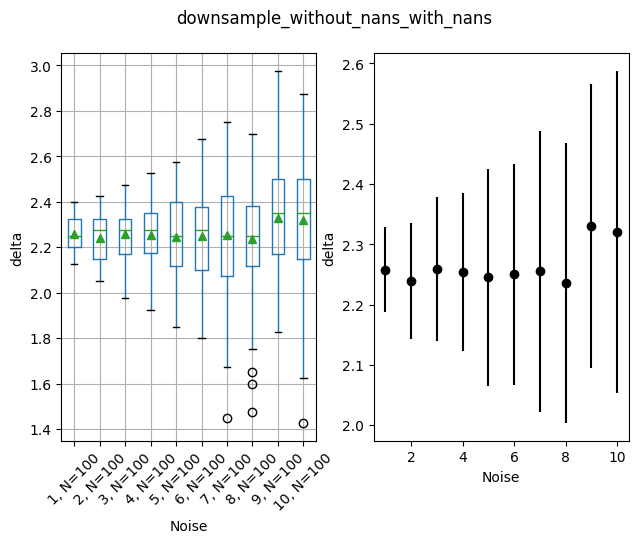

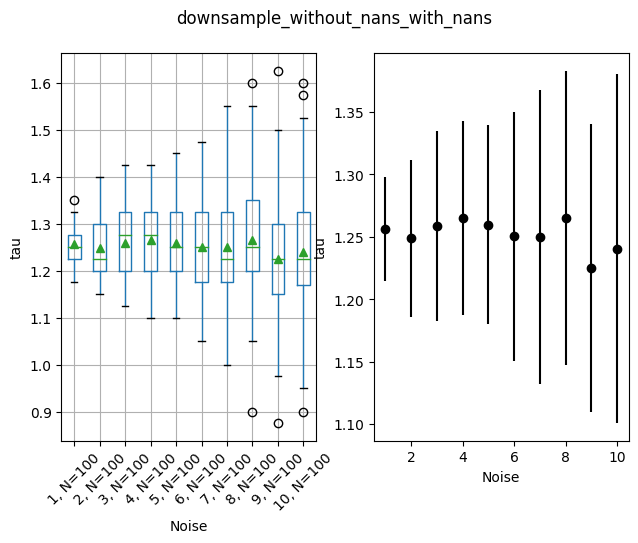

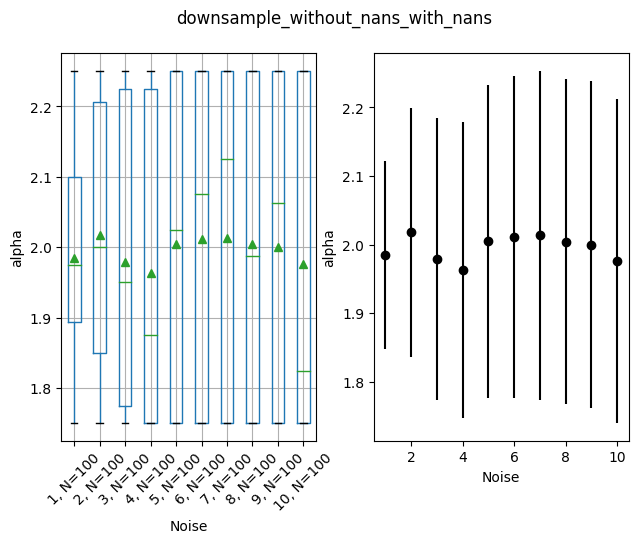

In [37]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [38]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [39]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [40]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        66    0.955246   2.099999999999996  1.1750000000000003   
1         1        82    1.044243   2.099999999999996  1.1750000000000003   
2         1         0    0.949749   2.099999999999996  1.2000000000000004   
3         1        28    0.971944   2.099999999999996  1.2000000000000004   
4         1        47    1.067070   2.099999999999996  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
3314     10        62  111.217088  2.7999999999999936  1.0750000000000002   
3315     10         2   90.622226  2.7999999999999936  1.2000000000000004   
3316     10        40  102.670517  2.8249999999999935  0.9500000000000002   
3317     10        16  107.479000  2.8249999999999935  1.0750000000000002   
3318     10        62  111.218523  2.8249999999999935  1.1000000000000003   

                   alpha  
0     2.2499999999999982  
1     2.2499999999999982  
2     2.2249999999999983  
3     2.2249999999999983  
4     2.2249999999999983  
...                  ...  
3314  1.8499999999999996  
3315                1.75  
3316  2.1249999999999987  
3317  1.9249999999999994  
3318               1.775  

[3319 rows x 6 columns]

In [68]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  5.58  0.986577  2.0  5.0  6.0  6.0  7.0
2                      100.0  4.60  1.740777  1.0  3.0  5.0  6.0  7.0
3                      100.0  3.78  2.077197  1.0  2.0  4.0  6.0  7.0
4                      100.0  3.04  1.874443  1.0  1.0  3.0  5.0  7.0
5                      100.0  2.87  1.988121  1.0  1.0  2.0  5.0  7.0
6                      100.0  2.25  1.805575  1.0  1.0  1.0  3.0  7.0
7                      100.0  1.94  1.455189  1.0  1.0  1.0  2.0  6.0
8                      100.0  2.15  1.719614  1.0  1.0  1.0  3.0  7.0
9                      100.0  2.12  1.713169  1.0  1.0  1.0  3.0  7.0
10                     100.0  2.19  1.679917  1.0  1.0  1.0  3.0  6.0

#### Local minima at edges

In [42]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [43]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost              delta                 tau  \
3060      9        39  84.100633  2.999999999999993  1.1000000000000003   
3061      9        39  84.099361  2.999999999999993  1.1250000000000004   

                   alpha  
3060  1.8249999999999997  
3061               1.775

In [44]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [45]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [46]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
496       1         0    0.949657  2.3249999999999953  1.3500000000000005   
497       1        29    1.000406  2.3249999999999953  1.3500000000000005   
545       1        25    0.977977   2.349999999999995  1.3500000000000005   
546       1        73    0.972478   2.349999999999995  1.3500000000000005   
547       1        91    1.102273   2.349999999999995  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
3287     10        76  102.802601  2.5749999999999944  1.2000000000000004   
3288     10        99  110.702756  2.5749999999999944  1.2000000000000004   
3290     10         6   93.549030  2.5749999999999944  1.3250000000000006   
3304     10        79  109.565804   2.724999999999994  1.1500000000000004   
3315     10         2   90.622226  2.7999999999999936  1.2000000000000004   

     alpha  
496   1.75  
497   1.75  
545   1.75  
546   1.75  
547   1.75  
...    ...  
3287  1.75  
3288  1.75  
3290  1.75  
3304  1.75  
3315  1.75  

[373 rows x 6 columns]

In [47]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        18      4   2.399999999999995    9    18      2  1.3250000000000006   
10       47     21   2.349999999999995    5    47     12  1.3250000000000006   
2        25      8   2.374999999999995    8    25      4  1.3500000000000005   
3        37     10   2.349999999999995    9    37      6  1.3500000000000005   
4        43     13   2.374999999999995    6    43      7  1.3500000000000005   
5        34     14  2.2749999999999955    5    34      9  1.3250000000000006   
6        43     17   2.399999999999995    6    43     11  1.3750000000000004   
7        41     19  2.4999999999999947    5    41     13  1.3000000000000005   
8        35     19  2.2999999999999954    4    35     12  1.2750000000000004   
9        50     23  2.4749999999999948    4    50     13  1.3250000000000006   

            
      freq  
noise       
1       13  
10      11  
2       10  
3       12  
4       12  
5        8  
6        7  
7        7  
8        6  
9        7

In [48]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        66    0.955246   2.099999999999996  1.1750000000000003   
1         1        82    1.044243   2.099999999999996  1.1750000000000003   
5         1        83    0.939023   2.099999999999996  1.2000000000000004   
6         1         3    1.086197   2.124999999999996  1.1750000000000003   
7         1        15    0.955299   2.124999999999996  1.1750000000000003   
...     ...       ...         ...                 ...                 ...   
3278     10        97  115.188993  2.5499999999999945  0.9750000000000002   
3279     10        64   98.406165  2.5499999999999945  1.0000000000000002   
3280     10         9   93.476936  2.5499999999999945  1.0250000000000004   
3291     10        97  115.190667  2.5999999999999943  0.9500000000000002   
3308     10        40  102.665274  2.7749999999999937  0.9250000000000002   

                   alpha  
0     2.2499999999999982  
1     2.2499999999999982  
5     2.2499999999999982  
6     2.2499999999999982  
7     2.2499999999999982  
...                  ...  
3278  2.2499999999999982  
3279  2.2499999999999982  
3280  2.2499999999999982  
3291  2.2499999999999982  
3308  2.2499999999999982  

[404 rows x 6 columns]

In [49]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        28      3   2.149999999999996   15    28      2  1.1750000000000003   
10       39     23  2.1999999999999957    3    39     19  1.1750000000000003   
2        32      7   2.124999999999996   10    32      3  1.1750000000000003   
3        27     11   2.099999999999996    6    27      5  1.2000000000000004   
4        32     14   2.149999999999996    4    32      7  1.2000000000000004   
5        42     17   2.174999999999996    8    42      9  1.1750000000000003   
6        46     21  1.9999999999999964    6    46     11  1.2000000000000004   
7        58     27   2.074999999999996    6    58     15  1.2000000000000004   
8        58     29  2.2249999999999956    6    58     16  1.2000000000000004   
9        42     23   2.124999999999996    7    42     11  1.1250000000000004   

            
      freq  
noise       
1       27  
10       5  
2       21  
3        8  
4        8  
5       10  
6        9  
7       12  
8       11  
9       10

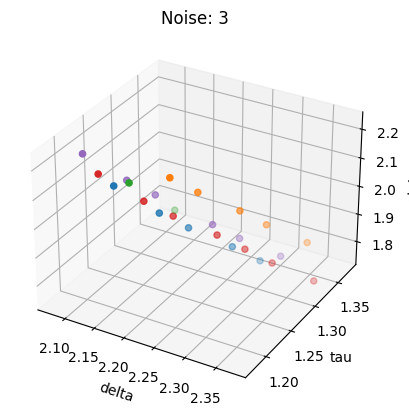

In [50]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

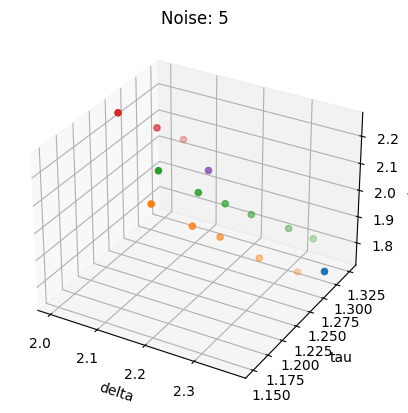

In [51]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

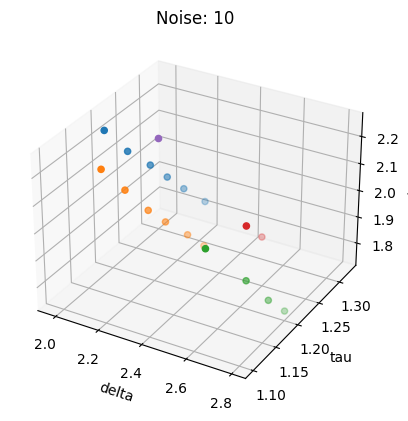

In [52]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [53]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [54]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [55]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        29    1.052808   2.099999999999996  1.2000000000000004   
1         1         0    0.975057   2.099999999999996  1.2000000000000004   
2         1        22    0.893412   2.099999999999996  1.2000000000000004   
3         1        31    0.954107   2.124999999999996  1.1750000000000003   
4         1        74    1.032906   2.124999999999996  1.1750000000000003   
...     ...       ...         ...                 ...                 ...   
3047     10        16  111.076883  2.8249999999999935  0.9750000000000002   
3048     10        16  111.085151  2.8499999999999934  1.0000000000000002   
3049     10        62  118.053457  2.8499999999999934  1.1000000000000003   
3050     10        96   98.480094  2.8499999999999934  1.2250000000000005   
3051     10        62  118.048448  2.8749999999999933  1.1250000000000004   

                   alpha  
0     2.1999999999999984  
1     2.2249999999999983  
2     2.2499999999999982  
3     2.2249999999999983  
4     2.2249999999999983  
...                  ...  
3047  2.0999999999999988  
3048   2.024999999999999  
3049  1.8249999999999997  
3050                1.75  
3051                1.75  

[3052 rows x 6 columns]

In [69]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  5.58  0.986577  2.0  5.0  6.0  6.0  7.0
2                      100.0  4.60  1.740777  1.0  3.0  5.0  6.0  7.0
3                      100.0  3.78  2.077197  1.0  2.0  4.0  6.0  7.0
4                      100.0  3.04  1.874443  1.0  1.0  3.0  5.0  7.0
5                      100.0  2.87  1.988121  1.0  1.0  2.0  5.0  7.0
6                      100.0  2.25  1.805575  1.0  1.0  1.0  3.0  7.0
7                      100.0  1.94  1.455189  1.0  1.0  1.0  2.0  6.0
8                      100.0  2.15  1.719614  1.0  1.0  1.0  3.0  7.0
9                      100.0  2.12  1.713169  1.0  1.0  1.0  3.0  7.0
10                     100.0  2.19  1.679917  1.0  1.0  1.0  3.0  6.0

#### Local minima at edges

In [57]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [58]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [59]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [60]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [61]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
482       1        48    1.073137  2.3249999999999953  1.3500000000000005   
497       1        31    0.943495   2.349999999999995  1.3250000000000006   
498       1        74    1.017604   2.349999999999995  1.3250000000000006   
499       1        82    1.077292   2.349999999999995  1.3250000000000006   
515       1        13    0.966576   2.349999999999995  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
3036     10        76   99.414267   2.649999999999994  1.1750000000000003   
3040     10        79  103.983438   2.724999999999994  1.1000000000000003   
3045     10         2   89.917600  2.7749999999999937  1.2750000000000004   
3050     10        96   98.480094  2.8499999999999934  1.2250000000000005   
3051     10        62  118.048448  2.8749999999999933  1.1250000000000004   

     alpha  
482   1.75  
497   1.75  
498   1.75  
499   1.75  
515   1.75  
...    ...  
3036  1.75  
3040  1.75  
3045  1.75  
3050  1.75  
3051  1.75  

[382 rows x 6 columns]

In [62]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        27      4   2.374999999999995   12    27      2  1.3250000000000006   
10       48     28   2.424999999999995    3    48     18  1.3250000000000006   
2        20      6  2.3249999999999953    7    20      5  1.3500000000000005   
3        35     10  2.3249999999999953    7    35      7  1.3000000000000005   
4        44     13   2.424999999999995    8    44      9  1.3000000000000005   
5        36     13   2.399999999999995    7    36      9  1.3750000000000004   
6        42     17   2.374999999999995    5    42     12  1.3250000000000006   
7        44     20   2.424999999999995    5    44     14  1.3750000000000004   
8        41     18  2.3249999999999953    6    41     16  1.2750000000000004   
9        45     22   2.449999999999995    4    45     16  1.2750000000000004   

            
      freq  
noise       
1       18  
10       6  
2        6  
3       10  
4       13  
5        7  
6        6  
7        6  
8        7  
9        6

In [63]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1        22    0.893412   2.099999999999996  1.2000000000000004   
6         1        26    1.003973   2.124999999999996  1.1750000000000003   
7         1        35    0.937084   2.124999999999996  1.1750000000000003   
8         1        37    1.031991   2.124999999999996  1.1750000000000003   
9         1        60    1.036006   2.124999999999996  1.1750000000000003   
...     ...       ...         ...                 ...                 ...   
3006     10        51  102.570672  2.4999999999999947  1.1750000000000003   
3021     10        86   94.169522  2.5749999999999944  0.9750000000000002   
3022     10         5   95.727352  2.5749999999999944  1.0500000000000003   
3031     10        64   96.376788  2.6249999999999942  0.9750000000000002   
3043     10        40  107.873194  2.7749999999999937  0.9750000000000002   

                   alpha  
2     2.2499999999999982  
6     2.2499999999999982  
7     2.2499999999999982  
8     2.2499999999999982  
9     2.2499999999999982  
...                  ...  
3006  2.2499999999999982  
3021  2.2499999999999982  
3022  2.2499999999999982  
3031  2.2499999999999982  
3043  2.2499999999999982  

[420 rows x 6 columns]

In [64]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        25      4   2.149999999999996   14    25      2  1.1750000000000003   
10       50     29   2.149999999999996    4    50     15  1.1750000000000003   
2        33      8   2.124999999999996    7    33      4  1.2000000000000004   
3        37     13   2.074999999999996    5    37      7  1.1500000000000004   
4        28     13   2.174999999999996    5    28      8  1.1750000000000003   
5        42     17   2.099999999999996    6    42     10  1.1750000000000003   
6        52     21  1.9749999999999965    6    52     13  1.1750000000000003   
7        52     24  1.9499999999999966    5    52     14  1.1750000000000003   
8        55     30   2.124999999999996    7    55     16  1.1750000000000003   
9        46     24  2.2999999999999954    5    46     13  1.1250000000000004   

            
      freq  
noise       
1       22  
10       6  
2       13  
3       12  
4        9  
5       11  
6        8  
7       10  
8        7  
9        8

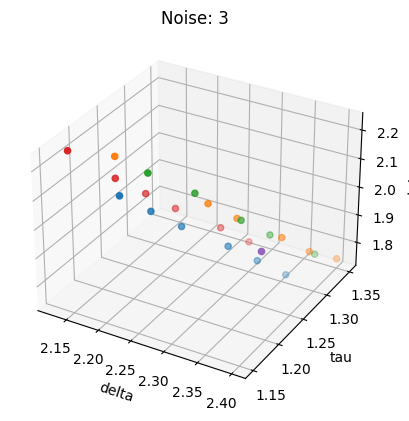

In [65]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

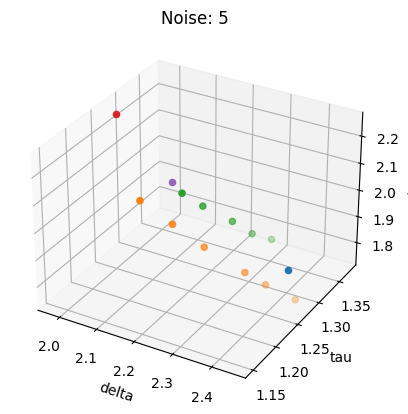

In [66]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

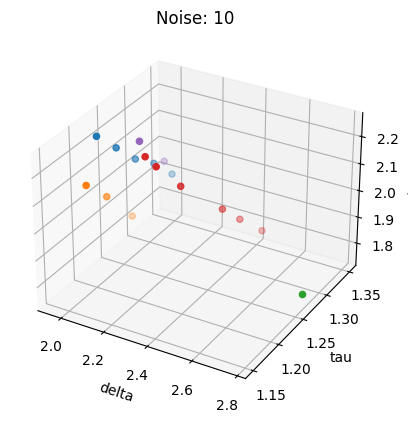

In [67]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()